# Bayesian Inference Lab 1 

Varun Nayyar

This is an Ipython notebook (an R equivalent now exists) that allows me to put my notes and code in a single place, before exporting a pdf or webpage I can use to review later on. 

## R

### Why?

* If you want to see how a recently developed method that was just published works, you can assured that the researcher's will implement their package in R, so seeing it's real world performance is as simple as installing the relevant package. 
* Any kind of method you want to use is available out of the box, you don't have to do much research and searching to find good implementations
* It's the default programming language used by most researching statisticians and knowledge of R is essential for any kind of research statistics. 
* It is easy to get started with for basic work.
* R is a language you have to know for a stats degree, it's NOT optional!

### Why Not?

* It is a one trick pony - it's good for stats, and that's it
    * Very poorly designed languaged
    * Over specialized - general purpose work is very difficult with R
* Very poor stability, large >100Mb datasets usually cause R to crash.
* Constantly in flux, R code written now is unlikely to work next year.
* Very difficult to deal with complexity, Object oriented design very poorly implemented.



## Python

### Why?
Python is a full featured and mature language, as such it

* Will work a year later, which is not the case with much R code. 
* Has very well designed features which makes writing complex code much easier. Even simple code is easier in Python.
* Has functionality to do many things like webscraping, webpage hosting, file parsing etc.
* Performance wise, Python tends to have extremely efficient algorithms implmented and is usually faster than R.  
* Superb package support, for nearly anything, you can just import it.
    * Numpy for fast (native C speeds) computations
    * Scipy for many useful functions in fields like signal processing, optimization, linalg, stats etc
    * Matplotlib (and ggplot, seaborn etc) for really nice visualisation
    * Pandas for powerful dataframes
    * PyMC for efficient Monte Carlo computations, with performance similar to BUGS
    * Rpy - call R code from Python!
  
### Why Not?

* Single threaded - does not scale well with available computing power
* Limited adoption by statistical community, and as such no packages available for implementation
* More general purpose makes initial learning curve a little steeper for stats use, but long term learning curve is much shallower than R.
    

##Other Languages

Julia has become popular of late due to performance promises, however it is even more bleeding edge than R and has very limited support. It is my opinion ([and others](https://darrenjw.wordpress.com/2013/12/23/scala-as-a-platform-for-statistical-computing-and-data-science/)) that taking a programming language and overspecialising is a bad approach (like R, Matlab etc.), I would much rather take a well designed general language and add numeric capabilities. This has the advantage of a well designed language with powerful data types with powerful numerics, as opposed to a language with powerful numerics and little else.

For those interested in Big Data, a functional language like [Scala](https://www.coursera.org/course/progfun), OCaml or Haskell would be worth learning (same language family as Julia). Due to the constraints of the language, far greater optimizations can be made, and this allows the program to scale from 1 computer to many with very little additional code. In contrast, Python and R are unable to use more than a single core for computation (unless written explicitly mutli-threaded which is quite difficult and not recommendend in general).

In [1]:
import numpy as np #very useful
from scipy.stats import gamma

shape = 24890 + 1
rate = 65+ 0.01
level = 0.05

gamRV = gamma(a = shape, scale = 1/rate) 

This creates a gamma random variable with useful functions and I don't have to keep specifying it's parameters (which is nice). For full usage features, check out the reference below 
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

In [2]:
lower = gamRV.ppf(0.025) # qgamma equivalent
lower

378.13762557414162

In [3]:
upper = gamRV.ppf(0.975)
upper

387.65062700867895

In [4]:
mean = gamRV.stats('m') #Theoretical mean, isn't that nice!
print mean

382.879556991


In [5]:
singleMCSet = gamRV.rvs(size = 500) #rgamma equivalent
MCSet = gamRV.rvs(size = (250,500)) #larger draw
MCSet[0, :20] # let's look at a bit of one of them

array([ 383.24493677,  382.28731786,  384.23149628,  382.05395576,
        381.55219461,  380.03232194,  382.57698159,  385.0215899 ,
        384.31104277,  382.77501859,  382.12532371,  384.6899978 ,
        380.40238288,  381.06589623,  383.76700382,  382.73350438,
        382.6346199 ,  384.18951446,  386.61929799,  380.60383129])

Note that I've drawn 250 lots of  500 values. This is an implementation problem. Python and R are high level languages  with low level language interfaces. This means simple constructs like loops are extremely slow and repeated calls to any function have high overhead. Rather than call gamRV.rvs 250 times, I call it once with more work and get the results with less work. And then you can use functions like `map` in python or `apply` in R to work on datasets quickly (these are loop like, but much quicker).

This is really not a problem when it's 250 repeats of 500 samples, but add a few zeros on to the end, and this becomes a problem. You might instead run into issues where you can't store all the data as it requires too much RAM, in which case the loop is unavoidable. 

Either way, I'll show both approaches here.

In [6]:
#loop approach

numMCruns = 250
numSamples = 500
lowVals = np.zeros(numMCruns) 
upperVals = np.zeros(numMCruns)
# empty vectors to store the data, since I know how much storage I need, it's better to preallocate

for i in range(numMCruns):
    singleMCSet = gamRV.rvs(size = numSamples)
    lowVals[i], upperVals[i] = np.percentile(singleMCSet, [2.5, 97.5]) 
    #double assignment is nice syntax

print lowVals[:10] 
print upperVals[:10] #Let's have a look at what we got

[ 378.34156013  377.85339006  378.29282497  377.92307584  378.36065726
  378.24494964  377.96984245  378.15971957  378.44345475  378.35025187]
[ 387.90265994  387.87673527  388.16069158  387.17139934  387.97616066
  387.38449086  387.61748533  386.81922159  387.70048234  387.18734328]


In [7]:
#Map/apply approach

MC = 250
nSamps = 500
#Turning this into a function for later use
def credInts(numMCruns = 250, numSamples=500):
    """
    Function Docstring:
    Numpy functions have automatic mapping, here I apply across the columns (axis=1), 
    so it treats each row as the dataset to apply the function,
    If i had it the other way around, i.e. size = (numSamples, numMCruns), 
    I would apply across the rows, i.e. axis = 0
    """
    MCSet = gamRV.rvs(size = (numMCruns,numSamples)) # 250 rows, 500 columns 
    lowVals, upperVals = np.percentile(MCSet,[2.5,97.5], axis = 1)
    return lowVals, upperVals

lowValsMap, upperValsMap = credInts(MC, nSamps)

print lowValsMap[:10]
print upperValsMap[:10]

[ 378.65934403  378.2650437   378.00742748  378.2738004   378.24372636
  378.38565483  378.23914725  378.52521871  377.98590629  378.57818421]
[ 388.07162424  388.19635642  388.30553121  387.59255553  387.64443269
  387.6120214   387.5967535   387.79540635  387.59278795  388.15541858]


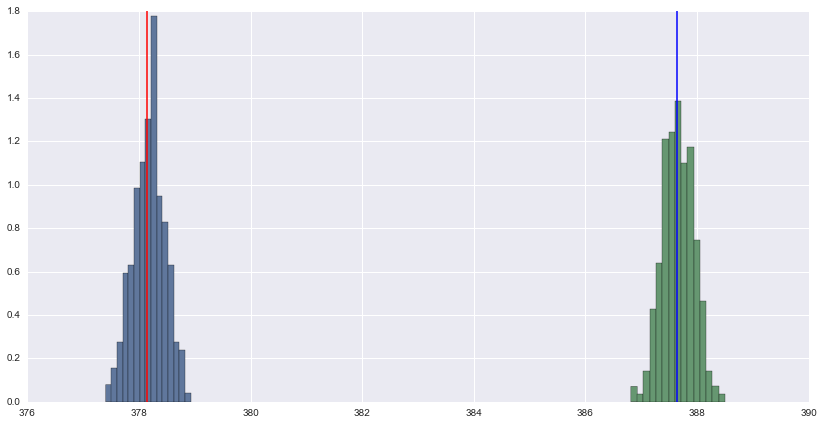

In [8]:
#Now lets plot
from matplotlib import pyplot as plt 
#using matlab style plotting package
%matplotlib inline 
# for displaying in the notebook

# from matplotlib.style import use
# use(['ggplot', 'fivethirtyeight']) #nicer graphics than default
import seaborn as sns
sns.set_palette("deep", desat=.6)

plt.figure(figsize=(14,7))
a = plt.hist(lowValsMap, normed=True, bins = 15)
b = plt.hist(upperValsMap, normed=True, bins = 15)

#true values
plt.axvline(lower, color = 'r', lw=1.5)
plt.axvline(upper, lw=1.5)

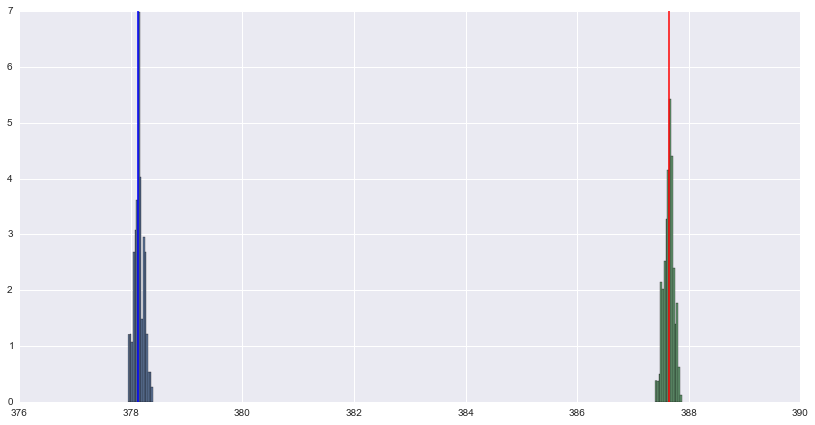

In [9]:
# let's use our previous function
low5k, upp5k = credInts(numMCruns=250, numSamples=5000)
plt.figure(figsize = (14,7))
plt.xlim((376, 390))
a = plt.hist(low5k, normed=True, bins = 15)
b = plt.hist(upp5k, normed=True, bins = 15)

#true values
plt.axvline(lower, lw = 1.5)
plt.axvline(upper, color='r', lw=1.5)

In [10]:
lowprec, uppprec = credInts(numMCruns=250, numSamples=70000)

print "Lrange: ", np.ptp(lowprec) #ptp = range finder
print "Urange: ", np.ptp(uppprec)

Lrange:  0.138896226532
Urange:  0.127944493935


It takes roughly 70,000 samples or so to reduce the range to 0.15 or so

In [11]:
# c)
from scipy.stats import nbinom
from numpy.random import poisson

#Posterior predictive = p(new data| current data)
# This is done by drawing from the posterior and using it's drawn value as the parameters in prediction
# This is a Monte Carlo approach to the integration problem

param = gamRV.rvs(10000)
# print param

predProb = poisson(param, len(param))
# print predProb, len(predProb)

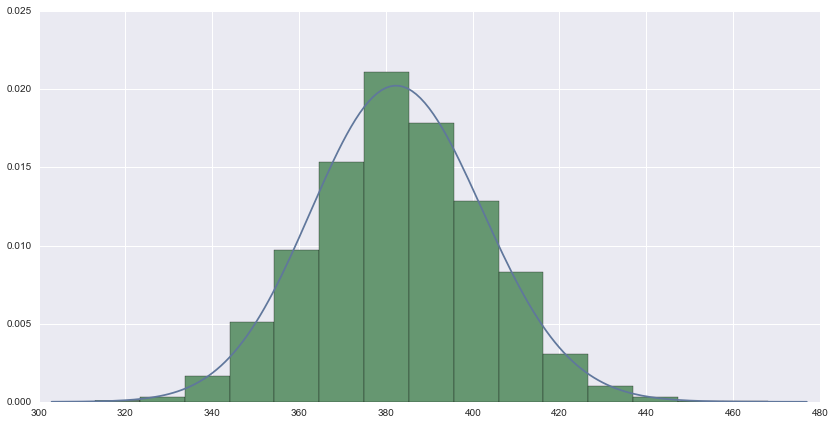

In [12]:
nbinRV = nbinom(n=shape, p = 1-1/(rate+1))
# set it to the requisite values

plt.figure(figsize=(14,7))
# print randVals[:50]
x = np.arange(min(predProb)-10, max(predProb)+10) #get integer values for x axis in same region

a = plt.plot(x, nbinRV.pmf(x)) #pmf = probability mass functions
a = plt.hist(predProb, normed=True, bins = 15)

1d
Obviously the algebraic approaches allow us to work with limited computation power, we get more exact answers more quickly, and as such we don't have to worry about issues such as convergence and correlation of samples.

However, if we don't choose convenient priors, we do obtain an intractable expression for the posterior, which means we are very limited if we choose to stay with algebraic analysis only.

### Part 2

For this part, I'm going to use pandas to read the data. pandas.DataFrame has much of the same functionality as R's tables and has many useful features included. I

In [13]:
import pandas as pd
dat = pd.read_table("Data/tuberculosis.txt", names = ['a', 'c', 'p', 'mu'], sep=' ')
dat.head()

,a,c,p,mu
0,0.637150,-0.035595,0.002734,0.143269
1,0.658784,-0.230571,0.021353,0.054053
2,0.643604,-0.007878,0.002139,0.061422
3,0.637183,-0.113469,0.001606,0.172285
4,0.697422,-0.780616,0.140234,0.047296


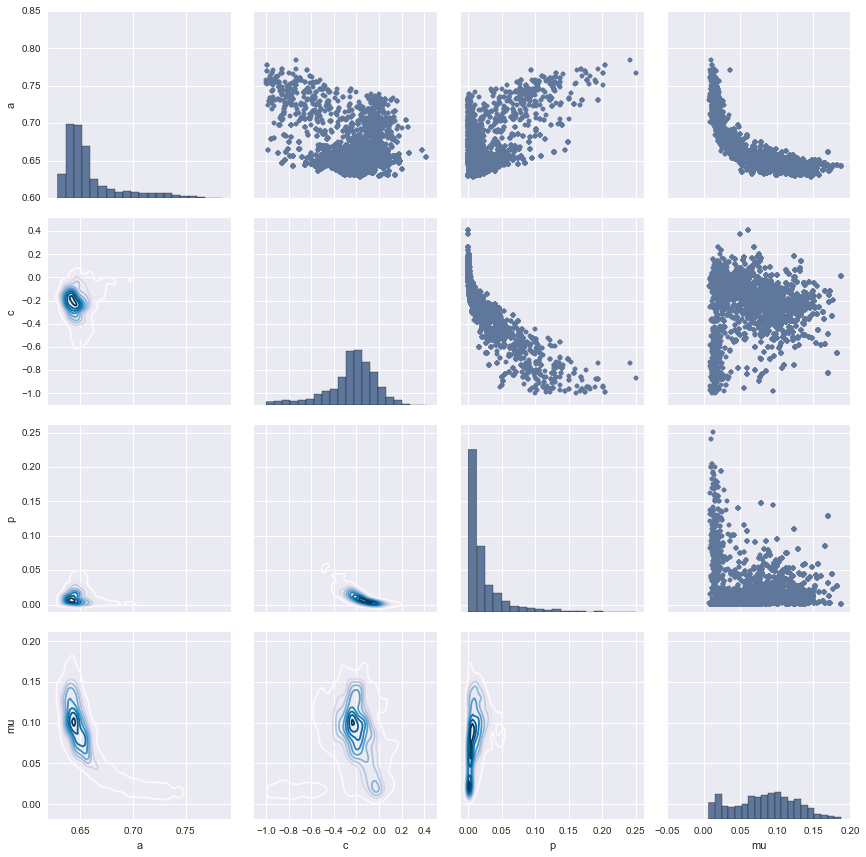

In [14]:
import seaborn as sns # nice multivariate visualisation library
p = sns.PairGrid(dat)
p.map_upper(plt.scatter)
p.map_diag(plt.hist, bins = 20)
p.map_lower(sns.kdeplot, cmap = "PuBu") 
# ^^this line quite slow for large datasets - but gives nice visualisations

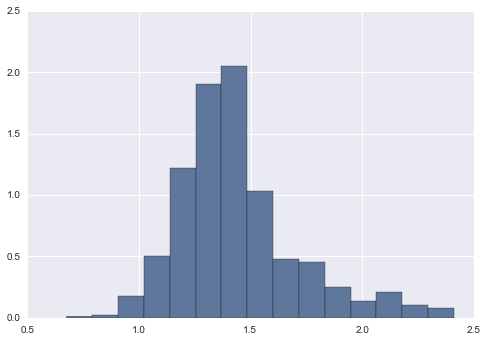

In [15]:
def relfitness(c, tau, delta, er, es, p):
    num = 1.0/tau + 1.0/(delta+er)
    denom = 1.0/tau + 1.0/(delta+es+p)
    return (1.0-c)* num/denom

#define useful function for this

phi = relfitness(dat['c'], tau = 0.52, delta = 0.52, er = 0.202, es = 0.52, p = dat['p'])
#note we can combine arrays and scalars in the same calculation
a = plt.hist(phi, normed = True, bins = 15)

In [16]:
#Now let's check P(\phi)<1
numLess1 = np.sum(phi<1) # yep as si
numTot = len(phi)

percentage = 1.0 * numLess1/numTot
print percentage

0.0206


In [17]:
#not much evidence eh?
#credible Interval again
low, upp = np.percentile(dat['p'], [2.5, 97.5])
print low, upp, upp-low

0.00032065 0.117538075 0.117217425


0.088362 2
Interval is :[0.0004, 0.9504]


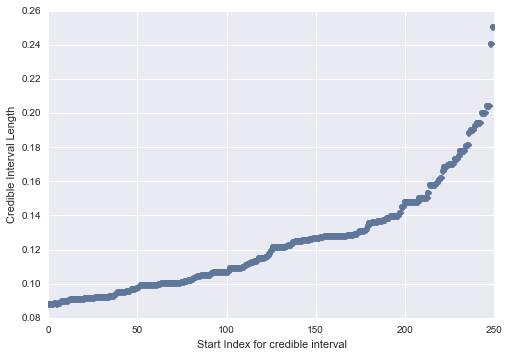

In [19]:
postLen = len(phi)
numIntervals = 0.05 * postLen
p = np.sort(dat['p'])
#I'm going to do this 250 times, sorting once and then looking up is easier than constantly 
# recalculating the percentiles!
intervalRange = np.zeros(numIntervals)

# print postLen, numIntervals
# loopmethod
for i in range(int(numIntervals)):
    intervalRange[i] = p[postLen-numIntervals + i] - p[i] #0 indexing

intervalRangeMap = p[postLen-numIntervals:] - p[:numIntervals] 
#mapping - avoiding loops and using default +- operators.
plt.plot(intervalRangeMap, 'o')
plt.xlabel("Start Index for credible interval")
plt.ylabel("Credible Interval Length")

index = np.argmin(intervalRangeMap)
print intervalRangeMap[index], index
print "Interval is :[{}, {}]".format(1.0 * index/postLen, 1.0 * (postLen-numIntervals+index)/postLen)

Obviously the more symmetric it is, the likelier it is that the central credible interval is the shortest one. This is left skewed, and clearly makes sense that the shortest interval is on the left.

##Buffon's Needle

Firstly I set the lines for Buffon's needle to be at integer values from [0,d]. This means I can simulate the position of the needle by choosing a random uniform value for the position of the needle centre and then choosing a uniform random angle of the needle (0 to \pi/2). This allows me calculate it's upper and lower endpoints, and then check if it crosses any integer values, i.e. does it start at value 1 and end in value 2.

In [20]:
def numhits(ystart, yend):
    """
    Function to calculate the number of needles cross a line, i.e. have changing integer values
    Note this is a "mapped" function with no loop.
    """
    return np.sum(np.abs(np.floor(yend) - np.floor(ystart)))


def Buffon(ratio = 1, d = 20, numtrials = 1e7):
    """
    ratio is length/distance
    D = number of lines - this won't change things much
    numtrials = how many times do you want to run it, 10^7 is about the max before memory limits come along.
    1 billion numbers ~ 80 MB of RAM
    """

    # Any larger trials and we hit memory limitations, and it'd be better to do everything in a loop
    length = ratio/2.0
    centers = np.random.uniform(0, d, numtrials)
    angle = np.random.uniform(0,np.pi, numtrials)

    # A = centers + length *

    ystart = centers - length* np.sin(angle)
    yend = centers + length* np.sin(angle)

    crosses = numhits(ystart, yend)

    estPi = (2.0/crosses) * numtrials
    return estPi
    
print Buffon()

3.14091264871


b) is quite trivial, it is obvious that at p=1, we have our minimum

In [21]:
p = np.linspace(0.05,1,25) # get some values of p
sdList =[]
for ratio in p:
    sds = [Buffon(ratio, numtrials = 1000) for i in range(1000)] #list comprehension
    sdList.append(np.std(sds))

# print sdList 

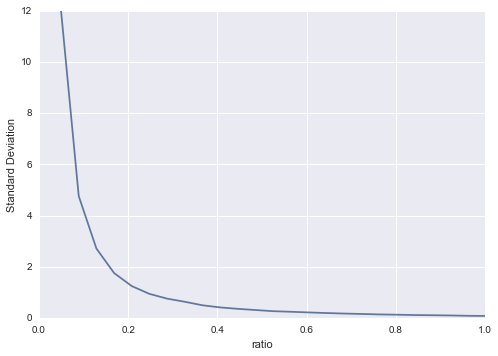

In [22]:
plt.plot(p, sdList)
plt.ylabel("Standard Deviation")
plt.xlabel("ratio")   

This shows that the standard deviation is indeed smaller for larger values of p, just as theoretically calculated